<h1><center>CS598 Deep Learning for Healthcare Spring 2023<br>Paper Reproduction Project</center></h1>

<h3><center>Gilberto Ramirez and Jay Kakwani<br><span style="font-family:monospace;">{ger6, kakwani2}@illinois.edu</span><br><font color="lightgrey">Group ID: 27 | Paper ID: 181</font></center></h3>

### Ablation Study :  18 hours (cutoff period) + 9 hours (gap period)

In this ablation study, we will process and run ablation for 18 hour ICU Stay. 

In this project, we aim to reproduce the paper [*Learning Task for Multitask Learning: Heterogeneous Patient Populations in the ICU* by (Suresh et al, 2018)](https://arxiv.org/abs/1806.02878). In this paper, the authors propose a novel two-step pipeline to predict in-hospital mortality across patient populations with different characteristics. The first step of the pipeline divides patients into relevant non-overlapping cohorts in an unsupervised way using a long short-term memory (LSTM) autoencoder followed by a Gaussian Mixture Model (GMM). The second step of the pipeline predicts in-hospital mortality for each patient cohort identified in the previous step using an LSTM based multi-task learning model where every cohort is considered a different task.
The paper claims that by applying this pipeline there will be better predictive results when compared to a model applied to the aggregate population using a single task learning model. According to the authors, the better performance given by this pipeline is due to the combination of a multi-task learning model leveraging shared knowledge across distinct patient groups and the way how those groups were created, i.e., identification using a data-driven method rather than relying on domain knowledge or auxiliary labels.

## 1. Data

This paper uses the publicly available [MIMIC-III database](https://www.nature.com/articles/sdata201635) which contains clinical data in a critical care setting. After reviewing the paper in detail, we decided to use [MIMIC-Extract](https://arxiv.org/abs/1907.08322), an open source pipeline by (Wang et al., 2020) for transforming the raw EHR data into usable [Pandas](https://pandas.pydata.org/) dataframes containing hourly time series of vitals and laboratory measurements after performing unit conversion, outlier handling, and aggregation of semantically similar features.

Unfortunately, the MIMIC-Extract pipeline misses two features the [paper code](https://github.com/mit-caml/multitask-patients) makes use of:
* `timecmo_chart` which indicates the timestamp of a patient after being declared in CMO (Comfort Measures Only) state. This feature comes from a MIMIC-III concept table called `code_status`.
* `sapsii` which contains the SAPS (Simplified Acute Physiology Score) II for the patient. This feature comes from another MIMIC-III concept table called `sapsii`.

As a result, there are three data files needed to run this notebook:
* `all_hourly_data.h5`, an HDF file resulting from running the MIMIC-Extract pipeline which is publicly available in GCP using [this link](https://console.cloud.google.com/storage/browser/mimic_extract) and referenced in the [MIMIC-Extract github repo](https://github.com/MLforHealth/MIMIC_Extract).
* `code_status.csv`, a CSV file holding the MIMIC concept table `CODE_STATUS` that can be generated following the instructions in [this link within the MIT-LCP github repo](https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts#generating-the-concepts-in-postgresql).
* `sapsii.csv`, a CSV file holding the MIMIC concept table `SAPSII` that can be generated following the instructions in [this link within the MIT-LCP github repo](https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts#generating-the-concepts-in-postgresql).

The functions used in this notebook assume the three files listed above are in the folder `../data/` by default. However, location can be changed using arguments to the functions that process the data.

All code needed to replicate the paper is in [our github repo](https://github.com/ger6-illini/dl4h-sp23-team27-project) inside a Python module called `mtl_patients`.

The first function from that module we will start using is `get_summaries()`. This function returns three summaries as dataframes:
1. A summary providing some statistics of all patients broken by careunit.
2. A summary providing some statistics of all patients broken by SAPS-II score quartile.
3. A summary providing some statistics of the 29 distinct physiological measurements used in the paper.

These summaries need two arguments to be created:
* `cutoff_hours` (default 24) which is the minimum number of hours a patient needs to stay in the ICU to be considered part of a cohort.
* `gap_hours` (default 12) which is the number of hours between the end of `cutoff_hours` and the moment a model can start making a mortality prediction.

The importance of these two arguments is his impact in the exception criteria used in the paper. In particular, the paper:
1. Excludes all patients that met the in-hospital mortality criteria before `cutoff period` + `gap period`.
2. Excludes patients that were discharged before `cutoff period` + `gap period`.

The in-hospital mortality criteria used in the paper is an extended one and not just considers patients who died but also patients with a CMO (Comfort Measures Only) note. That is considered in the summaries creation as well.

### 1.1. Summaries, 18 hours (cutoff period) + 9 hours (gap period)

Now let's run the `get_summaries()` function with `cutoff_hours` = 18 and `gap_hours` = 9:

In [1]:
# store/print start time to measure runtime
from datetime import datetime
import pytz
starttime = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start time: {starttime}')

Start time: 19/04/2023 22:42:58


In [2]:
# install `pytables` using `pip` if running from Paperspace since TensorFlow image does not have it
!pip install tables

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import sys
pathname = "../code/"
if pathname not in sys.path:
    sys.path.append("../code/")
pd.options.display.max_rows = 999

from mtl_patients import get_summaries
from mtl_patients import discover_cohorts
from mtl_patients import run_mortality_prediction_task

In [4]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
pat_summ_18_by_cu_df, pat_summ_18_by_sapsiiq_df, vitals_labs_summ_18_df = get_summaries(cutoff_hours=18, gap_hours=9)

Start Cell Execution at : 19/04/2023 22:43:40
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Creating summaries
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Merging dataframes to create X_full...
    Creating summary by careunit...
    Creating summary by SAPS II score quartile...
    Creating summary by vitals/labs...
    Done!
CPU times: user 8.27 s, sys: 3.33 s, total: 11.6 s
Wall time: 11.7 s


Let's now display the resulting summaries one at a time.

#### 1.1.1. Data summary by patients in each intensive care unit (ICU)

In [5]:
pat_summ_18_by_cu_df

,N,n,Class Imbalance,Age (Mean),Gender (Male)
Careunit,,,,,
CCU,5030,365,0.073,82.40,0.58
CSRU,7001,151,0.022,69.50,0.67
MICU,11636,1205,0.104,77.75,0.51
SICU,5271,443,0.084,72.64,0.52
TSICU,4324,315,0.073,67.16,0.60
Overall,33262,2479,0.075,74.53,0.57


In the previous summary, patients were broken in groups where each group is one of five careunits where patients were first admitted:
* CCU: Coronary Care Unit
* CSRU: Cardiac Surgery Recovery Unit
* MICU: Medical Intensive Care Unit
* SICU: Surgical Intensive Care Unit
* TSICU: Trauma Surgical Intensive Care Unit

In addition, an overall group was also added. The statistics provided by the summary are:
* `N`: The number of samples (patients) in the group.
* `n`: The number of samples (patients) meeting the in-hospital mortality criteria defined in the paper: patient died or had a note of "Do Not Resuscitate" (DNR) or had a note of "Comfort Measures Only" (CMO).
* `Class Imbalance`: Ratio of patients meeting the in-hospital mortality criteria defined in the paper, i.e., $\dfrac{\text{n}}{\text{N}}$.
* `Age (Mean)`: Mean age of patients for each group in years.
* `Gender (Male)`: Ratio of patients that are males.

This summary was prepared to match Table 1 in the original paper. There are differences between both that can be attributed to the way how data was preprocessed by MIMIC-Extract when compared to the preprocessing done by the authors back in 2018, before MIMIC-Extract became available, and that was not made available by the authors in [their code](https://github.com/mit-caml/multitask-patients).

#### 1.1.2. Data summary by patients in each SAPS-II score quartile

In [6]:
pat_summ_18_by_sapsiiq_df

,N,n,Class Imbalance,Age (Mean),Gender (Male),SAPS II (Min),SAPS II (Mean),SAPS II (Max)
SAPS II Quartile,,,,,,,,
0,7280,64,0.009,45.67,0.61,0,16.60,22
1,10170,271,0.027,68.87,0.58,23,27.74,32
2,8201,575,0.070,86.57,0.55,33,36.72,41
3,7611,1569,0.206,96.74,0.54,42,51.58,118
Overall,33262,2479,0.075,74.53,0.57,0,32.97,118


In the previous summary, patients were broken based on the quartile of the SAPS-II score assigned to them. As it can be seen, the four quartiles have the ranges $[0, 22], [23, 32], [33, 41], [42, 118] $. This was included in the authors code but not in the paper. It seems the class imbalance might have been the primary reason. As it is evident from the summary, most of the patients are in quartile $3$ since they are in an ICU and is expected their values are on the high side.

#### 1.1.3. Data summary for physiological measurements

In [7]:
vitals_labs_summ_18_df

,min,avg,max,std,N,pres.
variable,,,,,,
anion gap,5.00,13.64,50.00,3.89,180116,0.0834
bicarbonate,0.00,24.30,53.00,4.69,188876,0.0874
blood urea nitrogen,0.00,26.07,250.00,21.64,190791,0.0883
chloride,50.00,105.19,175.00,6.27,207455,0.0960
creatinine,0.10,1.39,46.60,1.48,191614,0.0887
diastolic blood pressure,0.00,60.95,307.00,14.09,1878856,0.8696
fraction inspired oxygen,0.21,0.53,1.00,0.19,96405,0.0446
glascow coma scale total,3.00,12.58,15.00,3.52,369777,0.1711
glucose,33.00,140.15,1591.00,56.60,505609,0.2340


In the previous summary, all vitals and lab measurements selected in the paper (29 in total) are listed with relevant statistics associated to it:
* `min` representing the minimum of the measurement observed in the vitals/labs.
* `avg` representing the average of the measurement observed in the vitals/labs.
* `max` representing the maximum of the measurement observed in the vitals/labs.
* `std` representing the standard deviation of the measurement observed in the vitals/labs.
* `N` representing the number of non `NaN` samples for the specific vital/lab measurement.
* `pres.` representing the portion of all possible hours across all patients, admissions, and ICU stays where at least one of the 104 vitals/labs measurements in the original MIMIC-Extract pipeline was taken.

All these measurements are based on the `vitals_labs_mean` dataframe in the MIMIC-Extract pipeline which provides average of vitals/labs on a per hour basis for each patient after going into an ICU.

## 2. Discovering Patient Cohorts

The paper uses a two-step pipeline to: 1) identify relevant patient cohorts, and 2) use those relevant cohorts as separate tasks in a multi-lask learning framework to predict in-hospital mortality. In this section, we will focus on the first step of the pipeline, i.e., patient cohort discovery.

In order to identify meaningful patient cohorts, the paper proposes to process the raw patient data in such a way that the result is a 3D matrix of shape $(P \times T \times F)$ where $P$ represents the number of patients, $T$ the number of timesteps, and $F$ the number of features as depicted in the figure below (in blue) which is partially based on Figure 2 of the original paper. All numbers shown in the figure below correspond to a specific experiment published in the paper in which the observation window is limited to the first $24$ hours (cutoff period) after a patient goes into a careunit and there is a gap of $12$ hours (gap period) between the end of the observation window and the beginning of the prediction window where the prediction task is in-hospital mortality.

Preparation of the data to get the 3D (blue) matrix is performed by a function called `prepare_data()` inside the `mtl_patients.py` module. This preparation consists of the following transformations taken from the paper and the author's code reference implementation:
1. Calculation of the mortality flag (prediction label) and mortality time for every patient in the dataset using an *extended* definition of mortality: death, a note of "Do Not Resuscitate" (DNR), or a note of "Comfort Measures Only" (CMO). In case any of these conditions are met for a patient, the corresponding mortality label is set to *True* and the corresponding mortality time is considered as the earliest time of any of the three conditions. After reviewing in detail the author's code implementation it seems mortality is based on deathtime and a CMO note but not DNR. However, the calculation of the time of death is based on the earliest time of the three conditions.
2. Data used for the prediction is only limited to the first certain amount of hours after a patient goes into the ICU. This amount of hours is called inside the code "a cutoff period" (observation window) and defines the period of data used to train all models. In addition, there is another number of hours called inside the code "the gap period" which represents the time between the end of the observation window and the beginning of the prediction window to prevent label leakage. All patients that died under the *extended* definition before the cutoff period plus the gap period or stayed less than the cutoff period are excluded from the experiment as part of this step. Also, all patients under the age of 15 are excluded (this is already part of the exclusion criteria of the MIMIC-Extract pipeline).
3. There are 29 vitals/labs timeseries selected by the paper. Only data within the cutoff period for vitals/labs is kept and rest is removed. This will be used for the rest of the machine learning pipeline.
4. All vitals/labs values are converted to z-scores so they all have zero mean and unit standard deviation. Those z-scores are rounded to the closest integer and clipped between $-4$ and $4$ or set to $9$ in case of `NaN`. This allows to map every vital/lab measurement (a float) to one of ten possible values $[-4, -3, -2, -1, 0, 1, 2, 3, 4, 9]$, so they can be converted to dummy values. After dummifying the vitals/labs, column for the $9$ values (`NaN`) is removed, and the resulting matrix is sparse and containing either $0$s or $1$s.
5. Every patient is padded with rows of zeroes for those hours that are missed. For example, if a patient only has vitals/labs for the first ten hours and the cutoff period is 24, code adds fourteen hours (rows) with zeroes for that patient. In the end, the matrix will have a size of $P \times T \times F$ as expected by the subsequent models.
6. Finally, static data (gender, age, and ethnicity) is converted to integers representing categories and dummified. In case of age, there are four buckets established; $(10, 30), (30, 50), (50, 70), (70, \infty)$; while ethnicity is broken into five buckets (asian, white, hispanic, black, other).
7. Cohort assignments based on first careunit or Simplified Acute Physiology Score (SAPS) II score quartile is calculated for each patient and returned as well.

![Figure 1](../img/paper-181-fig-1.png)

The `discover_cohorts()` function inside the `mtl_patients.py` module is the one implementing the pipeline shown in the figure above and then calling the `prepare_data()` function detailed previously as the first step. Once data has been processed, the function will break the data in training, validation, and test data sets in a $70\%/10\%/20\%$ proportion.

The training data is used to train an LSTM autoencoder. The main purpose of the LSTM autoencoder is to generate a fixed-length dense representation (embedding) of the sparse inputs trying to retain the most important parts of the inputs. The paper selected embeddings of size $50$ as the optimal dimension (hyperparameter). The purple box in the middle of the diagram above (a 2D matrix) represents the embeddings after the LSTM autoencoder learned the representation of the original 3D matrix of shape $(32537 \times 24 \times 232)$ where every row corresponds to a patient.

Once the embeddings are calculated, a Gaussian Mixture Model is applied using $3$ clusters (the value the authors considered optimal). The result are the three green boxes representing three cohorts discovered in an unsupervised way and grouping similar patients based on the three static and the 29 time-varying vitals/labs selected from the MIMIC-III database.

### 2.1. Cohort statistics at 18 hours 

The paper runs two experiments. The first experiment uses a cutoff period of 18 hours, a gap period of 9 hours, and three clusters. Let's run this first experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria:

In [8]:
from mtl_patients import discover_cohorts

In [9]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
cohort_unsupervised_18 = discover_cohorts(cutoff_hours=18, gap_hours=9, embedding_dim=100, cohort_unsupervised_filename='../data/unsupervised_clusters_18.npy')

Start Cell Execution at : 19/04/2023 22:47:46
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 18]...
        New X_discrete.shape: (618101, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 18 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1205 out of 11636
        SICU: 443 out of 5271
        CCU: 365 out of 5030
        CSRU: 151 out of 7001
        TSICU: 315 out of 4324
    Final shape of X: (33262, 18, 232)
  

Let's summarize the results of 18 hour experiment similar to what Table 3 of the paper shows.

In [11]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')

#----------------------------------------------------
# Let's create the summary for the 18 hour experiment

cohort_unsupervised_18 = np.load('../data/unsupervised_clusters_18.npy')

from mtl_patients import prepare_data
_, Y, _, _, subject_ids = prepare_data(cutoff_hours=18, gap_hours=9)

Start Cell Execution at : 19/04/2023 22:52:01
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 18]...
        New X_discrete.shape: (618101, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 18 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1205 out of 11636
        SICU: 443 out of 5271
        CCU: 365 out of 5030
        CSRU: 151 out of 7001
        TSICU: 315 out of 4324
    Final shape of X: (33262, 18, 232)
  

In [12]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_18_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_18}, dtype=int)

# calculate summaries per cohort (24 hours)
table3_a_df = cohort_unsupervised_18_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_a_df.loc[:, 'Experiment'] = '18 hours'
table3_a_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (18 hours)
table3_a_overall_df = table3_a_df.groupby(['*'] * len(table3_a_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_a_overall_df.index.name = 'Group'
table3_a_overall_df.loc[:, 'Experiment'] = '18 hours'
table3_a_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 24 hour tables and make cosmetic changes
table3_a_df = pd.concat([table3_a_df, table3_a_overall_df], axis=0)
table3_a_df.reset_index(inplace=True)
table3_a_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [13]:
#-----------------------------------
# assign
table3_df = table3_a_df

# calculate class imbalance
table3_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'n'] / table3_df.loc[:, 'N']
table3_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'Class Imbalance'].round(4)

In [14]:
table3_df = table3_a_df
table3_df

N     n  Class Imbalance
Experiment Cohort Type  Group                              
18 hours   Unsupervised 0       9608   829           0.0863
                        1      11030   862           0.0782
                        2      12624   788           0.0624
           Global       *      33262  2479           0.0745

Table above is the equivalent to Table 3 in the paper. We can see the results are different. Data from MIMIC-Extract might be different from the data used by the authors.

** TO-DO ** Comparative Analysis

### 2.2. Visualization of selected lab test and vital signs features

In this section, we will try to reproduce the results from Figure 4 (section 6.1.1) in the paper. In Figure 4, data from experiment 1 (24 hours) is used to create heatmap plots to determine if patients from different cohorts are physiologically distinct. To do that, we added the function `get_heatmap_data()` to get the mean of all z-scores by patient, by hour in the ICU, by cohort.

#### 2.2.1. Heatmap plots for experiment 1 (18 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 1 (18 hour cutoff period and 9 hour gap period):

In [15]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')

from mtl_patients import get_heatmap_data
import seaborn as sns
import matplotlib.pyplot as plt

labs_df, vitals_df = get_heatmap_data(cutoff_hours=18, gap_hours=9,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_18.npy')

Start Cell Execution at : 19/04/2023 22:54:10
CPU times: user 6.08 s, sys: 2.86 s, total: 8.94 s
Wall time: 7.57 s


Let's plot the heatmaps for the selected lab tests and vitals:

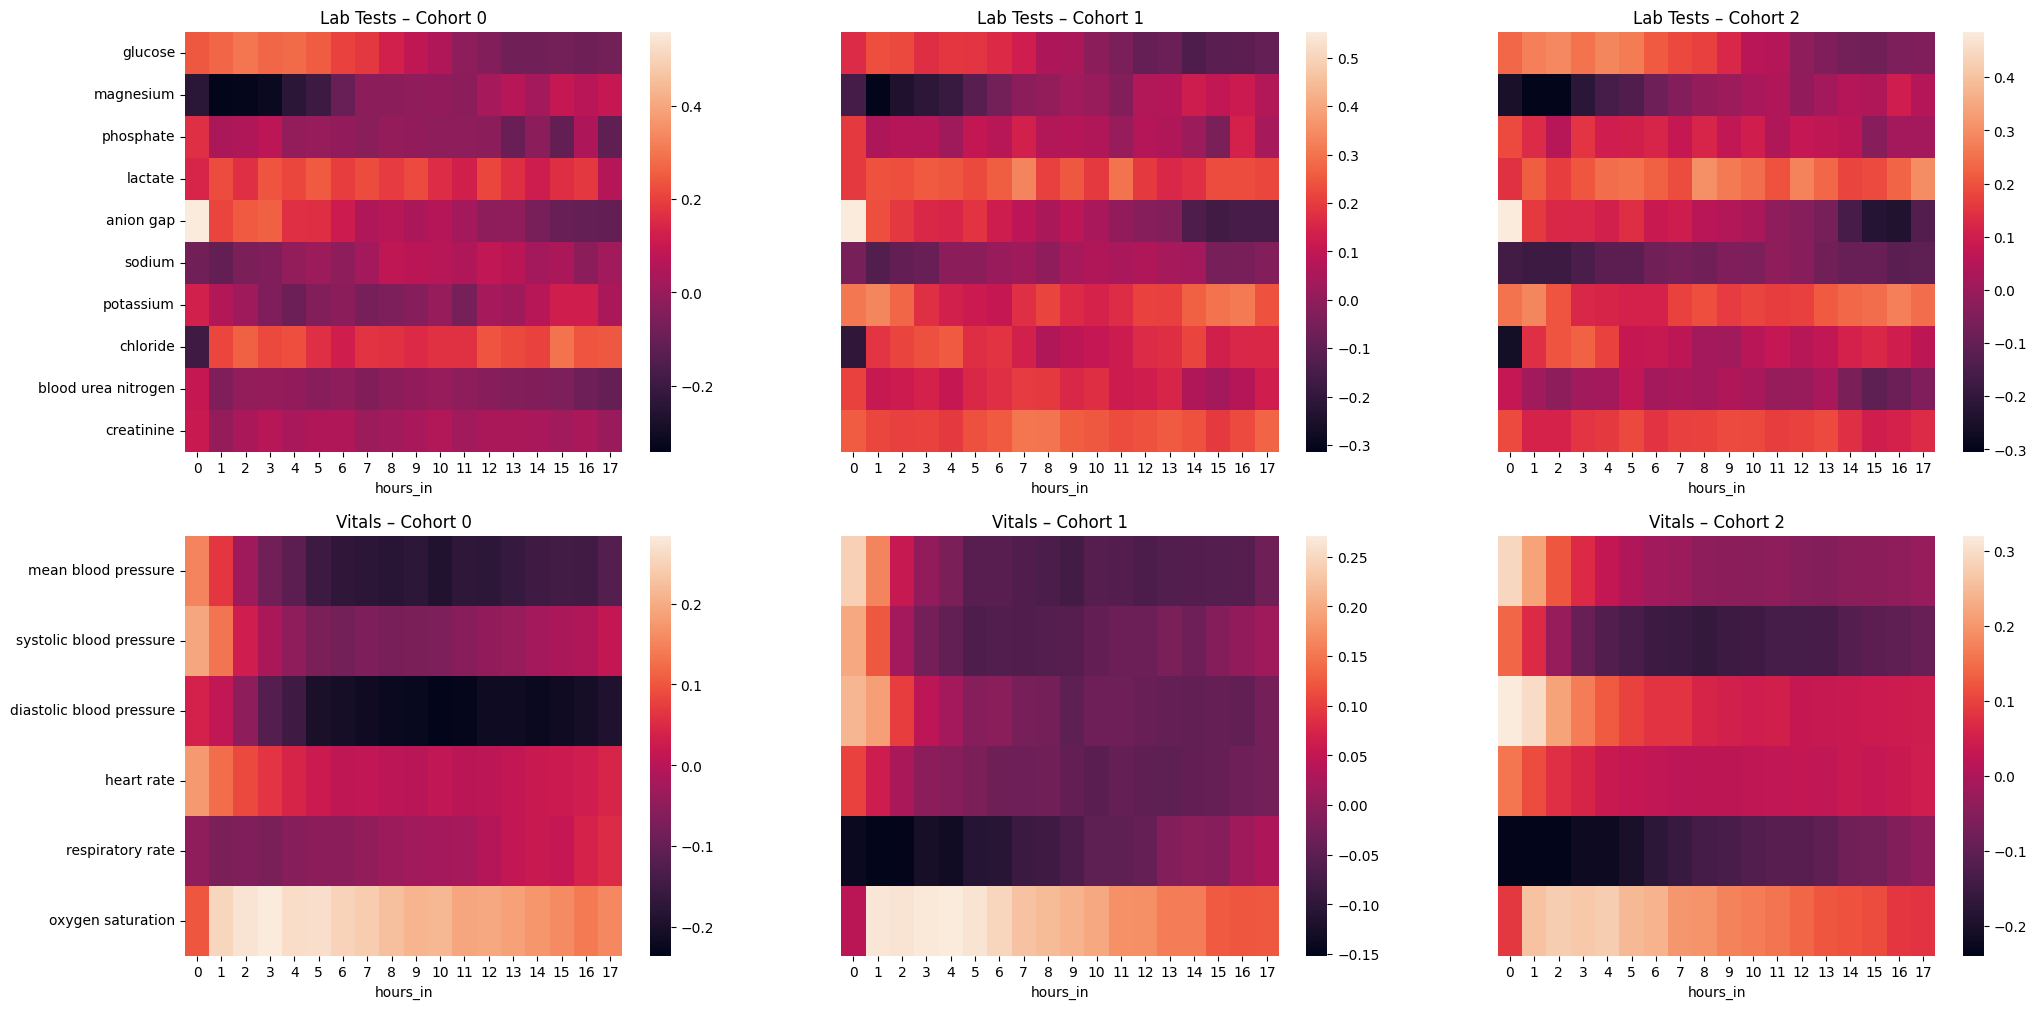

In [16]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_18')

From the heatmap plots there are some trends in the physiological data that seems to show a distinction between cohorts.

## 3. Predicting In-Hospital Mortality

As mentioned in the previous section, the paper uses a two-step pipeline to: 1) identify relevant patient cohorts, and 2) use those relevant cohorts as separate tasks in a multi-lask learning framework to predict in-hospital mortality. In this section, we will focus on the second step of the pipeline, i.e., use multi-task learning to make in-hospital mortality predictions for different patient cohorts.

The second step uses as input the result from the first step which is a series of 3D matrices, one per discovered cohort, of shape $(P \times T \times F)$ where $P$ represents the number of patients, $T$ the number of timesteps, and $F$ the number of features. As an example, the 24 hour experiment described by the authors in the paper and reproduced in the previous section resulted in three cohorts (clusters) called group 0, group 1, and group 2 where the shapes of the corresponding 3D matrices are:
* $14120 \times 24 \times 232$ for group 0,
* $10841 \times 24 \times 232$ for group 1, and
* $7752 \times 24 \times 232$ for group 2.

To convert these matrices into predictions, the paper proposes an LSTM for all model configurations including the baseline. In particular, the paper shows results from two specific models: a baseline model that is called *global* and using single-task learning and the multi-task learning model the authors claim as superior to the baseline.

A diagram of the baseline (*global*) model proposed by the authors is shown below. As it can be seen, this model consists of an LSTM layer of 16 cells using a RELU activation function followed by a *single* dense layer with a sigmoid activation function. The result of the dense (fully-connected) layer is an estimate of the probability of in-hospital mortality for a given patient. This baseline model is trained with all patient samples regardless the cohort, hence the name *global*, and used for per cohort predictions.

![Figure 2](../img/paper-181-fig-2.png)

Moving to the second model and the one the authors claim it provides benefits against the baseline is the so called *multi-task learning model*. This model consists of an LSTM layer with same number of cells (16) as the baseline model, to ensure the comparison is fair, connected to as many dense layers as population subgroups (cohorts). Each of these cohorts is considered a *task* and authors propose training these models on multiple tasks simultaneously in contrast to the baseline model with just one dense layer. The benefit of this approach according to the authors is the ability to share knowledge learned from one task (cohort) to rest of tasks under the assumption that the subpopulations used are distinct enough with relation to the outcome learned (mortality) that such shared knowledge truly exists. A representation of the multi-task learning model is shown below:

![Figure 3](../img/paper-181-fig-3.png)

For benchmarking purposes of the entire pipeline, the authors compared the results from running the pipeline using unsupervised cohort discovery (step one) against cohorts created using the first careunit the patient went into which can be considered an engineered feature. We will show those results in the next subsections.

The overall performance of this model is measured using both macro and micro metrics (section 4.3 in the paper) where:
* In *micro* metrics all predicted probabilities for all patients are treated as if they come from a single classifier: $\text{Metric}_\text{Micro} = \text{Metric}([\hat{y}_0, ..., \hat{y}_k], [y_0, ..., y_K])$.
* In *macro* metrics probabilities are evaluated on a *per cohort* basis, and then averaged: $\text{Metric}_\text{Macro} = \dfrac{1}{K} \displaystyle\sum_{k=0}^K \text{Metric}(\hat{y}_K, y_K)$.

Paper suggests that, although micro metrics are the ones typically chosen in the literature, evaluating performance on different subpopulations will benefit from macro metrics instead of micro metrics specially when there is class imbalance in every cohort. All results show macro and micro versions of the metrics for the aggregate performance of the models.

All results being used for comparison between models by the paper will use three metrics:
* AUC (Area Under the ROC Curve) for every cohort and, for the aggregate performance, macro and micro.
* PPV (Positive Predictive Value which is same as Precision) for every cohort and, for the aggregate performance, macro and micro. This PPV is calculated at a sensitivity of 80%, a value selected by the paper authors.
* Specificity for every cohort and, for the aggregate performance, macro and micro. This specificity is calculated at a sensitivity of 80%, a value selected by the paper authors.

All in-hospital mortality prediction tasks are implemented using the function `run_mortality_prediction_task()`. This function will call other functions to prepare the data, split the data in training/validation/test data sets, train the corresponding model, predict using the resulting model, and calculate the metrics of the model.

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

### 3.1. Predictions with Bootstrapping

In this section all in-hospital mortality predictions across the two models, global and multi-task learning, and for experiment 18 hours, are calculated for the three metrics; AUC, PPV (precision) @80% sensitivity, and Specificity @80% sensitivity; using 100 bootstrapped samples of the test set (20% of the original dataset). The results will be metrics (AUC, PPV, and Specificity) for each bootstrapped sample. This will allow the comparison between the global model and the multi-task learning model using the Wilcoxon signed-rank test as indicated in the paper.

#### 3.1.1. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 18 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 18 hour experiment setting. In this experiment, the cutoff period is 18 hours and the gap period is 9 hours, meaning model can only feed from patient data collected during the first 18 hours of the ICU stay, and predict mortality 27 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [17]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')

from mtl_patients import run_mortality_prediction_task

metrics_global_18_careunits_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=18, gap_hours=9, cohort_criteria_to_select='careunits', bootstrap=True)

Start Cell Execution at : 19/04/2023 22:56:31
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 18]...
        New X_discrete.shape: (618101, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 18 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1205 out of 11636
        SICU: 443 out of 5271
        CCU: 365 out of 5030
        CSRU: 151 out of 7001
        TSICU: 315 out of 4324
    Final shape of X: (33262, 18, 232)
  

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "CSRU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "MICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "SICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "TSICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 5min 41s, sys: 2min 18s, total: 7min 59s
Wall time: 6min 55s


In [20]:
pd.options.display.max_rows = 20
metrics_global_18_careunits_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
CCU    1       0.845  0.165        0.730
       2       0.792  0.172        0.711
       3       0.850  0.125        0.738
       4       0.848  0.157        0.729
       5       0.783  0.134        0.673
...              ...    ...          ...
Macro  96      0.870  0.203        0.779
       97      0.844  0.188        0.757
       98      0.857  0.181        0.742
       99      0.852  0.195        0.742
       100     0.828  0.162        0.671

[700 rows x 3 columns]

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [21]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
metrics_global_18_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=18, gap_hours=9, bootstrap=True,
                                                                         cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_18.npy')

Start Cell Execution at : 19/04/2023 23:04:58
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 18]...
        New X_discrete.shape: (618101, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 18 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1205 out of 11636
        SICU: 443 out of 5271
        CCU: 365 out of 5030
        CSRU: 151 out of 7001
        TSICU: 315 out of 4324
    Final shape of X: (33262, 18, 232)
  

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "1"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "2"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 5min 15s, sys: 2min, total: 7min 16s
Wall time: 6min 12s


In [22]:
metrics_global_18_unsupervised_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
0      1       0.851  0.275        0.793
       2       0.852  0.281        0.789
       3       0.826  0.218        0.751
       4       0.856  0.250        0.769
       5       0.850  0.256        0.766
...              ...    ...          ...
Macro  96      0.883  0.256        0.805
       97      0.850  0.213        0.754
       98      0.862  0.224        0.758
       99      0.863  0.253        0.781
       100     0.849  0.194        0.746

[500 rows x 3 columns]

#### 3.1.2. In-Hospital Mortality Prediction – Multi-Task Learning Model at 18 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 18 hour experiment setting. In this experiment, the cutoff period is 18 hours and the gap period is 9 hours, meaning model can only feed from patient data collected during the first 18 hours of the ICU stay, and predict mortality 27 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [23]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')

from mtl_patients import run_mortality_prediction_task

metrics_mtl_18_careunits_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=18, gap_hours=9, cohort_criteria_to_select='careunits', bootstrap=True)

Start Cell Execution at : 19/04/2023 23:13:16
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 18]...
        New X_discrete.shape: (618101, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 18 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1205 out of 11636
        SICU: 443 out of 5271
        CCU: 365 out of 5030
        CSRU: 151 out of 7001
        TSICU: 315 out of 4324
    Final shape of X: (33262, 18, 232)
  

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "CSRU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "MICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "SICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "TSICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 6min 21s, sys: 2min 18s, total: 8min 40s
Wall time: 7min 25s


In [24]:
pd.options.display.max_rows = 20
metrics_mtl_18_careunits_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
CCU    1       0.859  0.161        0.727
       2       0.787  0.133        0.607
       3       0.859  0.116        0.714
       4       0.845  0.137        0.683
       5       0.805  0.115        0.621
...              ...    ...          ...
Macro  96      0.868  0.207        0.784
       97      0.842  0.195        0.767
       98      0.857  0.181        0.742
       99      0.846  0.184        0.734
       100     0.839  0.175        0.717

[700 rows x 3 columns]

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [25]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
metrics_mtl_18_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=18, gap_hours=9, bootstrap=True,
                                                                      cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_18.npy')

Start Cell Execution at : 19/04/2023 23:21:06
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 18]...
        New X_discrete.shape: (618101, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 18 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1205 out of 11636
        SICU: 443 out of 5271
        CCU: 365 out of 5030
        CSRU: 151 out of 7001
        TSICU: 315 out of 4324
    Final shape of X: (33262, 18, 232)
  

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "1"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "2"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 5min 12s, sys: 1min 59s, total: 7min 11s
Wall time: 6min 13s


In [26]:
pd.options.display.max_rows = 20
metrics_mtl_18_unsupervised_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
0      1       0.841  0.209        0.706
       2       0.845  0.276        0.783
       3       0.827  0.157        0.628
       4       0.847  0.234        0.747
       5       0.837  0.218        0.710
...              ...    ...          ...
Macro  96      0.877  0.238        0.792
       97      0.846  0.217        0.757
       98      0.862  0.233        0.766
       99      0.856  0.225        0.753
       100     0.841  0.201        0.756

[500 rows x 3 columns]

#### 3.1.3. Summary

Similar to Table 4 in paper, the dataframe below summarizes all results. Due to bootstrapping we will get 100 metric (AUC, PPV, or Specificity) values for every combination of experiment (24 hours or 48 hours), cohort type (careunits or unsupervised), and model type (global or multi-task. We will reduce that table in a next step.

In [27]:
# Load multitask dfs if required
metrics_global_18_careunits_btstrp_df = pd.read_hdf('../data/results/model_global_18+9_careunits_bootstrap-ON.h5')
metrics_global_18_unsupervised_btstrp_df = pd.read_hdf('../data/results/model_global_18+9_unsupervised_bootstrap-ON.h5')
metrics_mtl_18_careunits_btstrp_df = pd.read_hdf('../data/results/model_multitask_18+9_careunits_bootstrap-ON.h5')
metrics_mtl_18_unsupervised_btstrp_df = pd.read_hdf('../data/results/model_multitask_18+9_unsupervised_bootstrap-ON.h5')

In [28]:
summary_a_btstrp_df = metrics_global_18_unsupervised_btstrp_df.reset_index()
summary_a_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_a_btstrp_df['Cohort type'] = 'Unsupervised'
summary_a_btstrp_df['Model'] = 'Global'
summary_a_btstrp_df['Experiment'] = '18 hours'

summary_b_btstrp_df = metrics_global_18_careunits_btstrp_df.reset_index()
summary_b_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_b_btstrp_df['Cohort type'] = 'Careunits'
summary_b_btstrp_df['Model'] = 'Global'
summary_b_btstrp_df['Experiment'] = '18 hours'

summary_c_btstrp_df = metrics_mtl_18_unsupervised_btstrp_df.reset_index()
summary_c_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_c_btstrp_df['Cohort type'] = 'Unsupervised'
summary_c_btstrp_df['Model'] = 'Multi-task'
summary_c_btstrp_df['Experiment'] = '18 hours'

summary_d_btstrp_df = metrics_mtl_18_careunits_btstrp_df.reset_index()
summary_d_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_d_btstrp_df['Cohort type'] = 'Careunits'
summary_d_btstrp_df['Model'] = 'Multi-task'
summary_d_btstrp_df['Experiment'] = '18 hours'

summary_18_btstrp_df = pd.concat([summary_a_btstrp_df, summary_b_btstrp_df, summary_c_btstrp_df, summary_d_btstrp_df])

# summary_e_btstrp_df = metrics_global_48_unsupervised_btstrp_df.reset_index()
# summary_e_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
# summary_e_btstrp_df['Cohort type'] = 'Unsupervised'
# summary_e_btstrp_df['Model'] = 'Global'
# summary_e_btstrp_df['Experiment'] = '48 hours'

# summary_f_btstrp_df = metrics_global_48_careunits_btstrp_df.reset_index()
# summary_f_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
# summary_f_btstrp_df['Cohort type'] = 'Careunits'
# summary_f_btstrp_df['Model'] = 'Global'
# summary_f_btstrp_df['Experiment'] = '48 hours'

# summary_g_btstrp_df = metrics_mtl_48_unsupervised_btstrp_df.reset_index()
# summary_g_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
# summary_g_btstrp_df['Cohort type'] = 'Unsupervised'
# summary_g_btstrp_df['Model'] = 'Multi-task'
# summary_g_btstrp_df['Experiment'] = '48 hours'

# summary_h_btstrp_df = metrics_mtl_48_careunits_btstrp_df.reset_index()
# summary_h_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
# summary_h_btstrp_df['Cohort type'] = 'Careunits'
# summary_h_btstrp_df['Model'] = 'Multi-task'
# summary_h_btstrp_df['Experiment'] = '48 hours'

# summary_48_btstrp_df = pd.concat([summary_e_btstrp_df, summary_f_btstrp_df, summary_g_btstrp_df, summary_h_btstrp_df])

# summary_btstrp_df = pd.concat([summary_24_btstrp_df, summary_48_btstrp_df])

summary_btstrp_df = summary_18_btstrp_df

# This is a trick using a categorical data type to have Macro and Micro after Cohort names while displaying
from pandas.api.types import CategoricalDtype
cohort = CategoricalDtype(['0', '1', '2', 'CCU', 'CSRU', 'MICU', 'SICU', 'TSICU', 'Macro', 'Micro'], ordered=True)
summary_btstrp_df['Cohort'] = summary_btstrp_df['Cohort'].astype(cohort)
summary_btstrp_df = summary_btstrp_df.dropna()

summary_btstrp_df = pd.melt(summary_btstrp_df, id_vars=['Cohort', 'Sample', 'Cohort type', 'Model', 'Experiment'], var_name='Metric')
summary_btstrp_df = summary_btstrp_df.set_index(['Experiment', 'Cohort type', 'Cohort', 'Sample'])
summary_btstrp_df = summary_btstrp_df.pivot(columns=['Metric', 'Model'], values='value')
summary_btstrp_df = summary_btstrp_df.round(3)
# Now summary_btstrp_df has all bootstrapped samples with right multi-indices for rows and columns!

##### 3.1.3.1. Mean values of metrics from bootstrapped samples

Let's get the mean values of the 100 bootstrapped samples:

In [29]:
pd.options.display.max_rows = 999
summary_df = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).mean().round(3).dropna()
summary_df

Metric                            AUC               PPV             \
Model                          Global Multi-task Global Multi-task   
Experiment Cohort type  Cohort                                       
18 hours   Careunits    CCU     0.826      0.830  0.162      0.150   
                        CSRU    0.904      0.889  0.137      0.105   
                        MICU    0.855      0.854  0.281      0.287   
                        SICU    0.809      0.820  0.190      0.211   
                        TSICU   0.871      0.863  0.218      0.213   
                        Macro   0.853      0.851  0.198      0.193   
                        Micro   0.865      0.866  0.224      0.227   
           Unsupervised 0       0.863      0.855  0.265      0.250   
                        1       0.839      0.841  0.178      0.181   
                        2       0.888      0.877  0.245      0.234   
                        Macro   0.863      0.858  0.229      0.221   
                        Micro   0.865      0.859  0.223      0.214   

Metric                         Specificity             
Model                               Global Multi-task  
Experiment Cohort type  Cohort                         
18 hours   Careunits    CCU          0.728      0.702  
                        CSRU         0.889      0.856  
                        MICU         0.765      0.773  
                        SICU         0.643      0.687  
                        TSICU        0.751      0.750  
                        Macro        0.755      0.754  
                        Micro        0.777      0.780  
           Unsupervised 0            0.787      0.767  
                        1            0.715      0.719  
                        2            0.820      0.811  
                        Macro        0.774      0.765  
                        Micro        0.775      0.762

##### 3.1.3.2 Wilcoxon Signed-Rank Test

Now it is time to apply the Wilcoxon Signed-Rank Test. [This video](https://www.youtube.com/watch?v=v4ZHlTbTOK8) has a very good detailed explanation of the Wilcoxon Signed-Rank Test which is a non-parametric version of the paired t-test used when there are not many samples (which is our case).

In [30]:
from scipy.stats import wilcoxon

def calc_wilcoxon(grp_df, what):
    if (what == 'auc'):
        # calculate p-value for AUC using Wilcoxon Signed Rank Test
        x = grp_df[('AUC', 'Global')]
        y = grp_df[('AUC', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)

    if (what == 'ppv'):
        # calculate p-value for PPV using Wilcoxon Signed Rank Test
        x = grp_df[('PPV', 'Global')]
        y = grp_df[('PPV', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)
    
    if (what == 'specificity'):
        # calculate p-value for AUC using Wilcoxon Signed=Rank Test
        x = grp_df[('Specificity', 'Global')]
        y = grp_df[('Specificity', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)

    return pvalue

In [31]:
summary_df.loc[:, ('AUC', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='auc')
summary_df.loc[:, ('PPV', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='ppv')
summary_df.loc[:, ('Specificity', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='specificity')
cols = [('AUC', 'Global'), ('AUC', 'Multi-task'), ('AUC', 'p-value'),
        ('PPV', 'Global'), ('PPV', 'Multi-task'), ('PPV', 'p-value'),
        ('Specificity', 'Global'), ('Specificity', 'Multi-task'), ('Specificity', 'p-value')]
summary_df = summary_df[cols]
summary_df

Metric                            AUC                             PPV  \
Model                          Global Multi-task       p-value Global   
Experiment Cohort type  Cohort                                          
18 hours   Careunits    CCU     0.826      0.830  9.489908e-04  0.162   
                        CSRU    0.904      0.889  4.991461e-13  0.137   
                        MICU    0.855      0.854  2.216654e-01  0.281   
                        SICU    0.809      0.820  1.134823e-13  0.190   
                        TSICU   0.871      0.863  2.085378e-07  0.218   
                        Macro   0.853      0.851  6.278749e-03  0.198   
                        Micro   0.865      0.866  5.162135e-02  0.224   
           Unsupervised 0       0.863      0.855  7.131375e-16  0.265   
                        1       0.839      0.841  4.327318e-02  0.178   
                        2       0.888      0.877  5.518656e-18  0.245   
                        Macro   0.863      0.858  1.900599e-17  0.229   
                        Micro   0.865      0.859  8.421750e-18  0.223   

Metric                                                  Specificity  \
Model                          Multi-task       p-value      Global   
Experiment Cohort type  Cohort                                        
18 hours   Careunits    CCU         0.150  2.967098e-09       0.728   
                        CSRU        0.105  3.537771e-13       0.889   
                        MICU        0.287  2.029032e-03       0.765   
                        SICU        0.211  2.863070e-11       0.643   
                        TSICU       0.213  6.387350e-01       0.751   
                        Macro       0.193  1.054349e-02       0.755   
                        Micro       0.227  3.897671e-02       0.777   
           Unsupervised 0           0.250  9.231651e-09       0.787   
                        1           0.181  1.220589e-01       0.715   
                        2           0.234  2.216231e-04       0.820   
                        Macro       0.221  4.312671e-08       0.774   
                        Micro       0.214  2.971699e-09       0.775   

Metric                                                   
Model                          Multi-task       p-value  
Experiment Cohort type  Cohort                           
18 hours   Careunits    CCU         0.702  2.650068e-09  
                        CSRU        0.856  3.373683e-12  
                        MICU        0.773  4.890382e-04  
                        SICU        0.687  5.806411e-11  
                        TSICU       0.750  9.958226e-01  
                        Macro       0.754  3.179575e-01  
                        Micro       0.780  4.271698e-02  
           Unsupervised 0           0.767  2.167479e-08  
                        1           0.719  1.890099e-01  
                        2           0.811  2.000922e-04  
                        Macro       0.765  2.087352e-06  
                        Micro       0.762  1.199918e-09

End time

In [48]:
# store/print end time to measure runtime
endtime = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'End time: {endtime}')

# store/print run time
print(f'This run took {datetime.strptime(endtime, "%d/%m/%Y %H:%M:%S") - datetime.strptime(starttime, "%d/%m/%Y %H:%M:%S")} hours:min:sec to run')

End time: 19/04/2023 23:41:08
This run took 0:58:10 hours:min:sec to run
